
# Reddit gender classification

## Data preprocessing

Various useful import

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import sklearn as sk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from scipy.sparse import csr_matrix, hstack
import pickle
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB



Importing train data from the cvs file, starting from the train data

In [116]:
train_data = pd.read_csv("data/train_data.csv", encoding="utf8")
train_data

,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate
...,...,...,...,...
296037,Tashre,FiftyFifty,1.391213e+09,I don't want to play this game anymore :(
296038,someguyfromtheuk,AskReddit,1.391213e+09,Twist: I am your son and staged all of this to...
296039,spurscanada,HIMYM,1.391213e+09,I think a lot of people don't like her because...
296040,SPAZZEH,politics,1.391213e+09,And the Tea Party must be having strokes right...


Then the test data

In [117]:
test_data = pd.read_csv("data/test_data.csv", encoding="utf8")
test_data

,author,subreddit,created_utc,body
0,ejchristian86,TwoXChromosomes,1.388534e+09,I hadn't ever heard of them before joining thi...
1,ZenDragon,gaming,1.388534e+09,"At 7680 by 4320 with 64x AA, right?"
2,savoytruffle,AskReddit,1.388534e+09,bite me
3,hentercenter,stlouisblues,1.388534e+09,Damn that was a good penalty :(
4,rick-o-suave,army,1.388534e+09,I swore into DEP on 6-OCT and I left 5-NOV und...
...,...,...,...,...
1107941,friedeggzohyeah,TrollXChromosomes,1.391213e+09,Oh god I my mom has celiac and has to buy insa...
1107942,im_a_leadfarmer,psychology,1.391213e+09,"Great, I guess i won't skip my 4th one at work..."
1107943,misandrical_unicorn,atheism,1.391213e+09,[k](http://gifrific.com/wp-content/uploads/201...
1107944,LevyWife,AskWomen,1.391213e+09,this is not a yahoo chat room.


Checking how many authors are present in the train data and the relative subreddits

In [118]:
print(train_data.author.unique().shape[0])
print(test_data.subreddit.unique().shape[0])
print(train_data.subreddit.unique().shape[0])

5000
3970
3468


Importing train data targets (gender)

In [119]:
train_target = pd.read_csv("data/train_target.csv")
train_target.head()

,author,gender
0,RedThunder90,0
1,Lirkmor,1
2,In0chi,0
3,ProjectGrudge,0
4,TehTurtleHermit,0


Visualizing data distribution over various class, 0 means men while 1 means women

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 414.78it/s]


Text(0, 0.5, '# of examples')

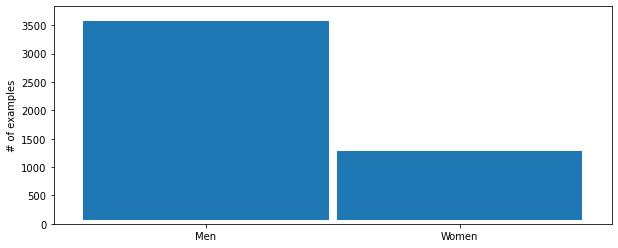

In [120]:


mydict = {0:"Men",1: "Women"}

target = train_target.copy()
for i in tqdm(range(len(mydict.keys()))):
    target["gender"]=target["gender"].replace(i,mydict[i])    


fig, ax = plt.subplots(figsize = (10,4))

N, bins, patches = ax.hist(target["gender"],bins=np.arange(0,3)-.5, edgecolor='white', linewidth=8, align="mid")

#settiamo colore diverse ad ogni classe

ax.set_ylabel("# of examples",)

Sorting data to get the same order on train data and target, then also the test data for completness

In [121]:
train_data = train_data.sort_values(by='author')
train_target = train_target.sort_values(by='author')
test_data = test_data.sort_values(by='author')
train_data.head()

,author,subreddit,created_utc,body
183217,-Jared,tall,1.390190e+09,+1 on the chiropractor. I went religiously fro...
284178,-Jared,AskReddit,1.391113e+09,And nothing beats a hangover quite like bacon ...
216135,-Jared,pics,1.390493e+09,Looks like the pattern on the envelope that mi...
284874,-Jared,AskReddit,1.391118e+09,"No, I think YOU mean Taylor Ham... Really, wha..."
183147,-Jared,AskReddit,1.390189e+09,Neil Diamond - Sweet Caroline


In [122]:
train_target.head()


,author,gender
1994,-Jared,0
1600,-Peeter,0
4757,-evasian,0
1177,-rubiks,1
3099,-true_neutral-,0


In [123]:
authors = test_data.author
authors = authors.to_list()
authors = set(authors)
test_data.head()


,author,subreddit,created_utc,body
469193,--redbeard--,AskReddit,1.389905e+09,Hi have brownish pubes but bright blonde eyebrows
489072,--redbeard--,glasgow,1.389971e+09,"Look into a ""a play, a pie and a pint"". I thin..."
88614,--redbeard--,YouShouldKnow,1.388831e+09,This got me through my masters degree
488987,--redbeard--,InsightfulQuestions,1.389970e+09,"Im not sure how relevant this is, but I have h..."
303114,--redbeard--,britishproblems,1.389384e+09,This is exactly what I do too


Setting the subreddit to involve in the training as the common one between train and test data

In [124]:
unique_test = test_data.subreddit.unique()
unique_train = train_data.subreddit.unique()

set_vec1 = set(unique_train)
set_vec2 = set(unique_test)

common_subreddit = set_vec1.intersection(set_vec2)
common_col = np.array(list(common_subreddit))

Once taking the subreddit to consider, taking only those ones in train and test set, selecting also the dataframe columns of 
interest, to get some author-subreddit dataframe

In [125]:
train_data = train_data[train_data['subreddit'].isin(common_col)]
train_data

,author,subreddit,created_utc,body
183217,-Jared,tall,1.390190e+09,+1 on the chiropractor. I went religiously fro...
284178,-Jared,AskReddit,1.391113e+09,And nothing beats a hangover quite like bacon ...
216135,-Jared,pics,1.390493e+09,Looks like the pattern on the envelope that mi...
284874,-Jared,AskReddit,1.391118e+09,"No, I think YOU mean Taylor Ham... Really, wha..."
183147,-Jared,AskReddit,1.390189e+09,Neil Diamond - Sweet Caroline
...,...,...,...,...
58992,zzrr,Portland,1.389067e+09,I heard there's a bakery going in there
192194,zzrr,outside,1.390271e+09,Yes\n\n[Idiotarod](http://en.wikipedia.org/wik...
96817,zzrr,Portland,1.389397e+09,&gt;Clardy wrote that he's tried to starve him...
280356,zzuil93,AskReddit,1.391076e+09,Love is like a meteorite. It goes as quick as ...


In [126]:
train_data_sub = train_data[['author', 'subreddit']]
train_data_sub


,author,subreddit
183217,-Jared,tall
284178,-Jared,AskReddit
216135,-Jared,pics
284874,-Jared,AskReddit
183147,-Jared,AskReddit
...,...,...
58992,zzrr,Portland
192194,zzrr,outside
96817,zzrr,Portland
280356,zzuil93,AskReddit


In [127]:
test_data = test_data[test_data['subreddit'].isin(common_col)]
test_data

,author,subreddit,created_utc,body
469193,--redbeard--,AskReddit,1.389905e+09,Hi have brownish pubes but bright blonde eyebrows
489072,--redbeard--,glasgow,1.389971e+09,"Look into a ""a play, a pie and a pint"". I thin..."
88614,--redbeard--,YouShouldKnow,1.388831e+09,This got me through my masters degree
488987,--redbeard--,InsightfulQuestions,1.389970e+09,"Im not sure how relevant this is, but I have h..."
303114,--redbeard--,britishproblems,1.389384e+09,This is exactly what I do too
...,...,...,...,...
233533,zzzuluz,AskReddit,1.389289e+09,Humantis!
673473,zzzuluz,bugout,1.390249e+09,&gt; If the argument is 'don't wear camo in a ...
495531,zzzuluz,funny,1.389985e+09,Catbacca
697809,zzzuluz,funny,1.390324e+09,Could still work.


In [128]:
test_data_sub = test_data[['author', 'subreddit']]
test_data_sub


,author,subreddit
469193,--redbeard--,AskReddit
489072,--redbeard--,glasgow
88614,--redbeard--,YouShouldKnow
488987,--redbeard--,InsightfulQuestions
303114,--redbeard--,britishproblems
...,...,...
233533,zzzuluz,AskReddit
673473,zzzuluz,bugout
495531,zzzuluz,funny
697809,zzzuluz,funny


Grouping data in a dataframe that has only author and then dummy encoded feature for subreddit

In [129]:
train_data_sub = train_data_sub.pivot_table(index='author', columns='subreddit', aggfunc=lambda x: int(len(x) > 0), fill_value=0)
train_data_sub.reset_index(inplace=True)
train_data_sub

subreddit,author,1022,1200isplenty,1911,195,2007scape,240sx,24hoursupport,2X_INTJ,30ROCK,...,yiff,yoga,youngjustice,youtube,youtubehaiku,yugioh,zelda,zen,zombies,zyzz
0,-Jared,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-Peeter,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-evasian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-rubiks,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-true_neutral-,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,zot13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4995,zottz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,zukinzo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,zzrr,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
test_data_sub = test_data_sub.pivot_table(index='author', columns='subreddit', aggfunc=lambda x: int(len(x) > 0), fill_value=0)
test_data_sub.reset_index(inplace=True)
test_data_sub


subreddit,author,1022,1200isplenty,1911,195,2007scape,240sx,24hoursupport,2X_INTJ,30ROCK,...,yiff,yoga,youngjustice,youtube,youtubehaiku,yugioh,zelda,zen,zombies,zyzz
0,--redbeard--,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-Allaina-,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-AllonsyAlonso,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-Beth-,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-Greeny-,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14969,zuesk134,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14970,zyfoxmaster150,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14971,zzcon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14972,zzzluap95,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Taking in account that selecting only common subreddit some test author have been eliminated, setting those authors and creating 
a dummy encoded dataframe to restore them (necessary for future kaggle testing)

In [131]:
less_authors = test_data_sub.author
less_authors = less_authors.to_list()
less_authors = set(less_authors)
to_add_authors = authors - less_authors
len(to_add_authors)


26

In [132]:
#rivedi se vuoi
rows = np.zeros(len(to_add_authors), dtype=int)
print(rows)
test_loss_authors = pd.DataFrame()

for sub in test_data_sub.columns:
    df = pd.DataFrame({sub : rows})
    test_loss_authors = pd.concat([test_loss_authors, df], axis=1)
test_loss_authors

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


,author,1022,1200isplenty,1911,195,2007scape,240sx,24hoursupport,2X_INTJ,30ROCK,...,yiff,yoga,youngjustice,youtube,youtubehaiku,yugioh,zelda,zen,zombies,zyzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
test_loss_authors['author'] = test_loss_authors['author'].astype(str)
for i, author in enumerate(to_add_authors):
    test_loss_authors.at[i, 'author'] = author
test_loss_authors    


,author,1022,1200isplenty,1911,195,2007scape,240sx,24hoursupport,2X_INTJ,30ROCK,...,yiff,yoga,youngjustice,youtube,youtubehaiku,yugioh,zelda,zen,zombies,zyzz
0,JokerReach,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ikbendusan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,krmeebs,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,heyleslie228,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SmallSizeBitch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,nateeld,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,UnCerveau,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Xevamir,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,tommorell,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Miss_Pink25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Adding these authors to get the whole test data dummy encoded 

In [134]:
test_data_sub = pd.concat((test_data_sub, test_loss_authors), axis=0)
test_data_sub = test_data_sub.sort_values(by='author')
test_data_sub

,author,1022,1200isplenty,1911,195,2007scape,240sx,24hoursupport,2X_INTJ,30ROCK,...,yiff,yoga,youngjustice,youtube,youtubehaiku,yugioh,zelda,zen,zombies,zyzz
0,--redbeard--,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-Allaina-,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-AllonsyAlonso,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-Beth-,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-Greeny-,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14969,zuesk134,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14970,zyfoxmaster150,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14971,zzcon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14972,zzzluap95,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Selecting only authors and body columns of starting dataset to aggregate every authors word in order to get train and test dataframe with only unique authors and all the words written by them


In [135]:
train_data_com = train_data[['author', 'body']]
train_data_com = train_data_com.groupby('author')['body'].agg(lambda x: ' '.join(x)).reset_index()
train_data_com


,author,body
0,-Jared,+1 on the chiropractor. I went religiously fro...
1,-Peeter,"Just read the FAQ, really."
2,-evasian,Although the ringer on/off toggle would do wha...
3,-rubiks,AlunaGeorge - Best Be Believing\nArctic Monkey...
4,-true_neutral-,She ran a pub that only served the Choctaw Nat...
...,...,...
4994,zot13,Hey! I think that is exactly what happened to ...
4995,zottz,Go to Whole Foods and get some [Feel Goodz](ht...
4996,zukinzo,I'm afraid the only good thing that will do is...
4997,zzrr,"ah yeah, wrong flower shop I heard there's a b..."


In [136]:
test_data

,author,subreddit,created_utc,body
469193,--redbeard--,AskReddit,1.389905e+09,Hi have brownish pubes but bright blonde eyebrows
489072,--redbeard--,glasgow,1.389971e+09,"Look into a ""a play, a pie and a pint"". I thin..."
88614,--redbeard--,YouShouldKnow,1.388831e+09,This got me through my masters degree
488987,--redbeard--,InsightfulQuestions,1.389970e+09,"Im not sure how relevant this is, but I have h..."
303114,--redbeard--,britishproblems,1.389384e+09,This is exactly what I do too
...,...,...,...,...
233533,zzzuluz,AskReddit,1.389289e+09,Humantis!
673473,zzzuluz,bugout,1.390249e+09,&gt; If the argument is 'don't wear camo in a ...
495531,zzzuluz,funny,1.389985e+09,Catbacca
697809,zzzuluz,funny,1.390324e+09,Could still work.


In [137]:
test_data = pd.read_csv("data/test_data.csv", encoding="utf8")
test_data = test_data.sort_values(by='author')

In [138]:
test_data_com = test_data[['author', 'body']]

test_data_com = test_data_com.groupby('author')['body'].agg(lambda x: ' '.join(x.astype(str))).reset_index()
test_data_com


,author,body
0,--redbeard--,Hi have brownish pubes but bright blonde eyebr...
1,-Allaina-,Same at my work. I worked in an all male team ...
2,-AllonsyAlonso,I think the more important thing in a relation...
3,-Beth-,what the actual fuck\n It's not a conscious th...
4,-Greeny-,Do you say that because you no longer need to ...
...,...,...
14995,zuesk134,i wasn't specifically talking about you when i...
14996,zyfoxmaster150,I laughed. Can I ask what medium? DADDY GOT HI...
14997,zzcon,go find a good bartender and tip him well. con...
14998,zzzluap95,&gt; A month later I sold Messi for 1.4k\n\nಠ_...


Performing TF-IDF text analysis on the authors'words to get sparse matrix containing this information

In [139]:
stop_words = set(list(ENGLISH_STOP_WORDS))
pattern ='(?u)\\b[A-Za-z]{3,}'
author_text_train = train_data_com['body']
author_text_train = list(author_text_train)

text_encoder = sk.feature_extraction.text.TfidfVectorizer(token_pattern=pattern, stop_words=stop_words, max_features = 1000)
author_text_train = text_encoder.fit_transform(author_text_train)
author_text_train

<4999x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 814593 stored elements in Compressed Sparse Row format>

In [140]:
author_text_test = test_data_com['body']
author_text_test = list(author_text_test)
text_encoder_test = sk.feature_extraction.text.TfidfVectorizer(token_pattern=pattern, stop_words=stop_words, max_features = 1000)
author_text_test = text_encoder_test.fit_transform(author_text_test)
author_text_test

<15000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2431592 stored elements in Compressed Sparse Row format>

Proccesing the dataframe to aggregate all informations in a unique sparse matrix for train and for test

In [141]:
body_train = author_text_train
authors_train = (train_data_sub['author']).to_numpy()
subreddit_train = (train_data_sub.drop('author', axis=1)).to_numpy()
subreddit_train = csr_matrix(subreddit_train)
body_test = author_text_test
authors_test = (test_data_sub['author']).to_numpy()
subreddit_test = (test_data_sub.drop('author', axis=1)).to_numpy()
subreddit_test = csr_matrix(subreddit_test)

In [142]:
common_author = train_data_sub.author.unique()
common_author = np.array(common_author)
train_target = train_target.loc[train_target['author'].isin(common_author)]
train_target = (train_target.drop('author', axis=1)).to_numpy()


In [143]:
train_data = hstack((body_train, subreddit_train))
train_data

<4999x4405 sparse matrix of type '<class 'numpy.float64'>'
	with 863653 stored elements in COOrdinate format>

In [144]:
test_data = hstack((body_test, subreddit_test))
test_data

<15000x4405 sparse matrix of type '<class 'numpy.float64'>'
	with 2576490 stored elements in COOrdinate format>

## Model implementation and training

Trying the first model (to see if the probabilistic approach is the right one), so checking results only on the train data

In [145]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression ()
lr.fit(train_data, train_target.ravel())

LogisticRegression()

In [146]:
train_acc = accuracy_score(train_target, lr.predict(train_data))
train_acc

0.9357871574314863

Implementing and looking for the best parameter for a more robust model, the Multinomial Naive Bayes

In [147]:
MNB = MultinomialNB()

alphas = np.logspace(-4, 10, 1000)
scores_MNB = []

for alpha in alphas:
    MNB.alpha = alpha
    score = model_selection.cross_val_score(MNB, train_data, train_target.ravel(), cv=10) # processo viene eseguito 10 volte, e ridà 10 valori diversi per ognugna delle parti valutate
    scores_MNB.append(np.mean(score))

Best alpha: 0.7868571506936851
Best score: 0.8689735470941885


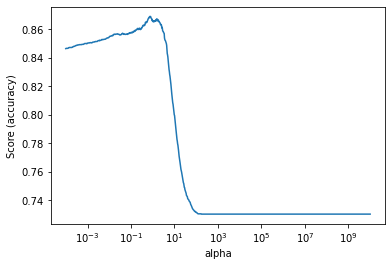

In [148]:
print ('Best alpha:', alphas[np.argmax(scores_MNB)])
print ('Best score:', scores_MNB[np.argmax(scores_MNB)])
#ax.hline(np.max(scores_MNB), linestyle='--', color='.5')

plt.semilogx(alphas, scores_MNB)
plt.xlabel('alpha')
plt.ylabel('Score (accuracy)')
best_alpha = alphas[np.argmax(scores_MNB)]

Training the model with the best parameter value

In [149]:
best_MNB = MultinomialNB(alpha = best_alpha)
best_MNB.fit(train_data,train_target.ravel())


MultinomialNB(alpha=0.7868571506936851)

Building the solution in the format required by kaggle competion

In [150]:
y_pred = best_MNB.predict_proba(test_data)[:,1]


In [151]:
authors_train = (train_data_sub['author']).to_numpy()
authors_test = (test_data_sub['author'])
authors_test = set(authors_test)
authors_test = np.array(list(authors_test))
authors_test = np.sort(authors_test)
authors_test

array(['--redbeard--', '-Allaina-', '-AllonsyAlonso', ..., 'zzcon',
       'zzzluap95', 'zzzuluz'], dtype='<U20')

In [152]:
solution = pd.DataFrame({"author":authors_test, "gender":y_pred})
solution

,author,gender
0,--redbeard--,0.103296
1,-Allaina-,0.991570
2,-AllonsyAlonso,0.030621
3,-Beth-,0.229474
4,-Greeny-,0.054785
...,...,...
14995,zuesk134,0.201528
14996,zyfoxmaster150,0.001618
14997,zzcon,0.042616
14998,zzzluap95,0.051356


Saving the final solution to submit in csv format

In [153]:
solution.to_csv("BestSolutionCA_try.csv", index=False)